<a href="https://colab.research.google.com/github/tanvir-152/Thesis_Codes/blob/main/FuNet_C_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   For Indian Pines
*   Concatenation Fusion Model of Base Paper

  OA: 0.8053

  AA: 0.8922
  
  K: 0.7784

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!pip install -U gast==0.2.2

In [ ]:
!pip install tensorflow==1.14

ERROR: Could not find a version that satisfies the requirement tensorflow==1.14 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow==1.14


In [ ]:
!pip install tensorflow-determinism

In [ ]:
#import library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio
import scipy.io as sio
from tf_utils import random_mini_batches_GCN1
from tensorflow.python.framework import ops
#from tfdeterminism import patch
#patch()
import tensorflow.compat.v1 as v1
#tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()


In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [ ]:
import tensorflow as tf

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = tf.cast(tf.shape(K)[-1], tf.float32)
    scores = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(d_k)

    if mask is not None:
        scores += (mask * -1e9)

    attention_weights = tf.nn.softmax(scores, axis=-1)
    output = tf.matmul(attention_weights, V)
    return output, attention_weights


In [ ]:
def create_placeholders(n_x, n_x1, n_y):

    isTraining = v1.placeholder_with_default(True, shape=())
    x_in = v1.placeholder(tf.float32,  [None, n_x], name = "x_in")
    x_in1 = v1.placeholder(tf.float32,  [None, n_x1], name = "x_in1")
    y_in = v1.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap_train = v1.placeholder(tf.float32, [None, None], name = "lap_train")

    return x_in, x_in1, y_in, lap_train, isTraining


In [ ]:
from tensorflow.python.ops.variables import VariableV1
def initialize_parameters():

    v1.set_random_seed(1)

    x_w1 = v1.get_variable("x_w1", [200,128], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_b1 = v1.get_variable("x_b1", [128], initializer = v1.zeros_initializer())

    x_jw1 = v1.get_variable("x_jw1", [128+128,128], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_jb1 = v1.get_variable("x_jb1", [128], initializer = v1.zeros_initializer())

    x_jw2 = v1.get_variable("x_jw2", [128,16], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_jb2 = v1.get_variable("x_jb2", [16], initializer = v1.zeros_initializer())

    x_conv_w1 = v1.get_variable("x_conv_w1", [3,3,200,32], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_conv_b1 = v1.get_variable("x_conv_b1", [32], initializer = v1.zeros_initializer())

    x_conv_w2 = v1.get_variable("x_conv_w2", [3,3,32,64], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_conv_b2 = v1.get_variable("x_conv_b2", [64], initializer = v1.zeros_initializer())

    x_conv_w3 = v1.get_variable("x_conv_w3", [1,1,64,128], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
    x_conv_b3 = v1.get_variable("x_conv_b3", [128], initializer = v1.zeros_initializer())

    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_jw1": x_jw1,
                  "x_jb1": x_jb1,
                  "x_jw2": x_jw2,
                  "x_jb2": x_jb2,
                  "x_conv_w1": x_conv_w1,
                  "x_conv_b1": x_conv_b1,
                  "x_conv_w2": x_conv_w2,
                  "x_conv_b2": x_conv_b2,
                  "x_conv_w3": x_conv_w3,
                  "x_conv_b3": x_conv_b3}

    return parameters

In [ ]:

def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)

    return x_out

In [ ]:
def max_ele(x_gcn,x_cnn):
  print(x_gcn.shape)
  print(x_cnn.shape)

In [ ]:
def mynetwork(x, x1, parameters, Lap, isTraining, momentums = 0.9):

    x1 = tf.reshape(x1, [-1, 7, 7, 200], name = "x1")

    with tf.name_scope("x_layer_1"):

         x_z1_bn = v1.layers.batch_normalization(x, momentum = momentums, training = isTraining)
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)

         x_conv_z1 = v1.nn.conv2d(x1, parameters['x_conv_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b1']
         x_conv_z1_bn = v1.layers.batch_normalization(x_conv_z1, momentum = momentums, training = isTraining)
         x_conv_z1_po = v1.layers.max_pooling2d(x_conv_z1_bn, 2, 2, padding='SAME')
         x_conv_a1 = tf.nn.relu(x_conv_z1_po)

    with tf.name_scope("x_layer_2"):

         x_conv_z2 = v1.nn.conv2d(x_conv_a1, parameters['x_conv_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b2']
         x_conv_z2_bn = v1.layers.batch_normalization(x_conv_z2, momentum = momentums, training = isTraining)
         x_conv_z2_po = v1.layers.max_pooling2d(x_conv_z2_bn, 2, 2, padding='SAME')
         x_conv_a2 = tf.nn.relu(x_conv_z2_po)

    with tf.name_scope("x_layer_3"):

         x_conv_z3 = v1.nn.conv2d(x_conv_a2, parameters['x_conv_w3'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b3']
         x_conv_z3_bn = v1.layers.batch_normalization(x_conv_z3, momentum = momentums, training = isTraining)
         x_conv_z3_po = v1.layers.max_pooling2d(x_conv_z3_bn, 2, 2, padding='SAME')
         x_conv_a3 = tf.nn.relu(x_conv_z3_po)

         x_conv_a3_shape = x_conv_a3.get_shape().as_list()
         x_conv_z3_2d = tf.reshape(x_conv_a3, [-1, x_conv_a3_shape[1] * x_conv_a3_shape[2] * x_conv_a3_shape[3]])

         joint_encoder_layer = tf.concat([x_a1, x_conv_z3_2d ], 1)

    with tf.name_scope("x_joint_layer_1"):
        x_zj1 = tf.matmul(joint_encoder_layer, parameters['x_jw1']) + parameters['x_jb1']
        x_zj1_bn = v1.layers.batch_normalization(x_zj1, momentum=momentums, training=isTraining)
        x_aj1 = tf.nn.relu(x_zj1_bn)



    with tf.name_scope("x_layer_4"):
        x_zj2 = tf.matmul(x_aj1, parameters['x_jw2']) + parameters['x_jb2']


    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_jw1']) + tf.nn.l2_loss(parameters['x_jw2'])\
               + tf.nn.l2_loss(parameters['x_conv_w1']) + tf.nn.l2_loss(parameters['x_conv_w2'])  + tf.nn.l2_loss(parameters['x_conv_w3'])

    return x_zj2, l2_loss

In [ ]:
def mynetwork_optimaization(y_est, y_re, l2_loss, reg, learning_rate, global_step):

    y_re = tf.squeeze(y_re, name = 'y_re')

    with tf.name_scope("cost"):
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = y_re)) + reg * l2_loss

    with tf.name_scope("optimization"):
         update_ops = v1.get_collection(v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = v1.group([optimizer, update_ops])

    return cost, optimizer

In [ ]:
def confusion_mat(x_out, y_in):
  x_cls = tf.transpose(x_out)
  y_cls = tf.transpose(y_in)
  x_cls = tf.argmax(x_out, 1)
  # x_cls = tf.nn.embedding_lookup(np.identity(16), x_cls_)
  # x_cls = convert_to_one_hot(np.array(x_cls)-1, 16)
# TrLabel = TrLabel.T
  y_cls = tf.argmax(y_in, 1)
  confusion = v1.confusion_matrix(y_cls, x_cls, 16)
  return x_cls, y_cls, confusion

In [ ]:
def train_mynetwork(x_train, x_test, train_x, test_x, y_train, y_test, L_train, L_test, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()
    v1.set_random_seed(1)
    seed = 1
    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape
    (m, n_x1) = train_x.shape

    costs = []
    costs_dev = []
    train_acc = []
    val_acc = []

    x_in, x_in1, y_in, lap_train, isTraining = create_placeholders(n_x, n_x1, n_y)

    parameters = initialize_parameters()

    with tf.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, x_in1, parameters, lap_train, isTraining)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = v1.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)

    with tf.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y_in)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    with tf.name_scope("con"):
         x_cls, y_cls, confusion = confusion_mat(x_out,y_in)

    init = v1.global_variables_initializer()

    with v1.Session() as sess:

        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs + 1):
            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_GCN1(x_train, train_x, y_train, L_train, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_x1, batch_y, batch_l) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x_in: batch_x, x_in1: batch_x1, y_in: batch_y, lap_train: batch_l, isTraining: True})

                epoch_cost += minibatch_cost / (num_minibatches+ 1)
                epoch_acc += minibatch_acc / (num_minibatches + 1)


            if print_cost == True and (epoch) % 50 == 0:
                features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x_in: x_test, x_in1: test_x, y_in: y_test, lap_train: L_test, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, epoch_cost_dev, epoch_acc, epoch_acc_dev))

            if print_cost == True and epoch % 10 == 0:
                costs.append(epoch_cost)
                train_acc.append(epoch_acc)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)

            if print_cost == True and epoch == 200:
                # con_mat =
                x, y, confusion = sess.run([x_cls, y_cls, confusion], feed_dict={x_in: x_test, x_in1: test_x, y_in: y_test, lap_train: L_test, isTraining: False})

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        return parameters, val_acc, features, x, y, confusion


In [ ]:
X_train = scio.loadmat('HSI_CNN/X_train.mat')
X_test = scio.loadmat('HSI_CNN/X_test.mat')
Train_X = scio.loadmat('HSI_GCN/Train_X.mat')
TrLabel = scio.loadmat('HSI_GCN/TrLabel.mat')
Test_X = scio.loadmat('HSI_GCN/Test_X.mat')
TeLabel = scio.loadmat('HSI_GCN/TeLabel.mat')
Train_L = scio.loadmat('HSI_GCN/Train_L.mat')
Test_L = scio.loadmat('HSI_GCN/Test_L.mat')



X_train = X_train['X_train']
X_test = X_test['X_test']
Train_X = Train_X['Train_X']
Test_X = Test_X['Test_X']
TrLabel = TrLabel['TrLabel']
TeLabel = TeLabel['TeLabel']

Train_L = Train_L['Train_L']
Test_L = Test_L['Test_L']


TrLabel = convert_to_one_hot(TrLabel-1, 16)
TeLabel = convert_to_one_hot(TeLabel-1, 16)
TrLabel = TrLabel.T
TeLabel = TeLabel.T

<ipython-input-95-b8ce4618a851>:7: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = v1.layers.batch_normalization(x, momentum = momentums, training = isTraining)
<ipython-input-95-b8ce4618a851>:9: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
<ipython-input-95-b8ce4618a851>:13: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future vers

epoch 0: Train_loss: 2.087028, Val_loss: 2.321810, Train_acc: 0.403086, Val_acc: 0.223865
epoch 50: Train_loss: 0.257570, Val_loss: 1.306780, Train_acc: 0.995739, Val_acc: 0.708717
epoch 100: Train_loss: 0.178716, Val_loss: 0.887389, Train_acc: 1.000000, Val_acc: 0.814083
epoch 150: Train_loss: 0.141293, Val_loss: 0.897001, Train_acc: 1.000000, Val_acc: 0.803019
epoch 200: Train_loss: 0.116888, Val_loss: 0.871985, Train_acc: 1.000000, Val_acc: 0.801572


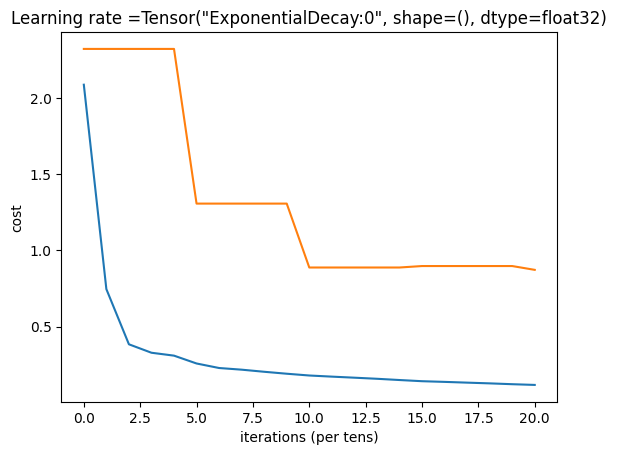

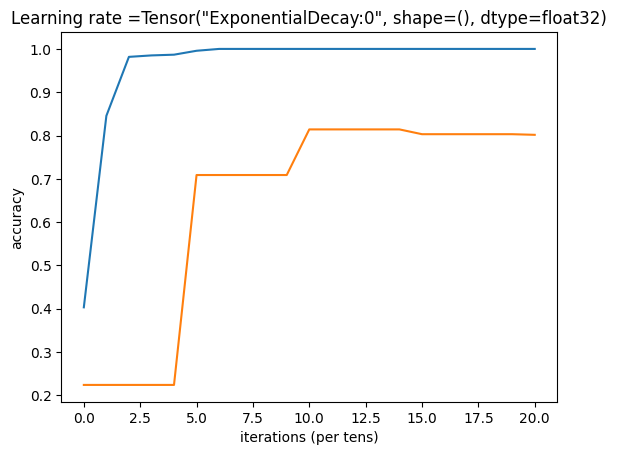

Parameters have been trained!


In [ ]:
parameters, val_acc, features, x, y, confusion = train_mynetwork(Train_X, Test_X, X_train, X_test, TrLabel, TeLabel, Train_L, Test_L)
sio.savemat('features.mat', {'features': features})

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

<Axes: >

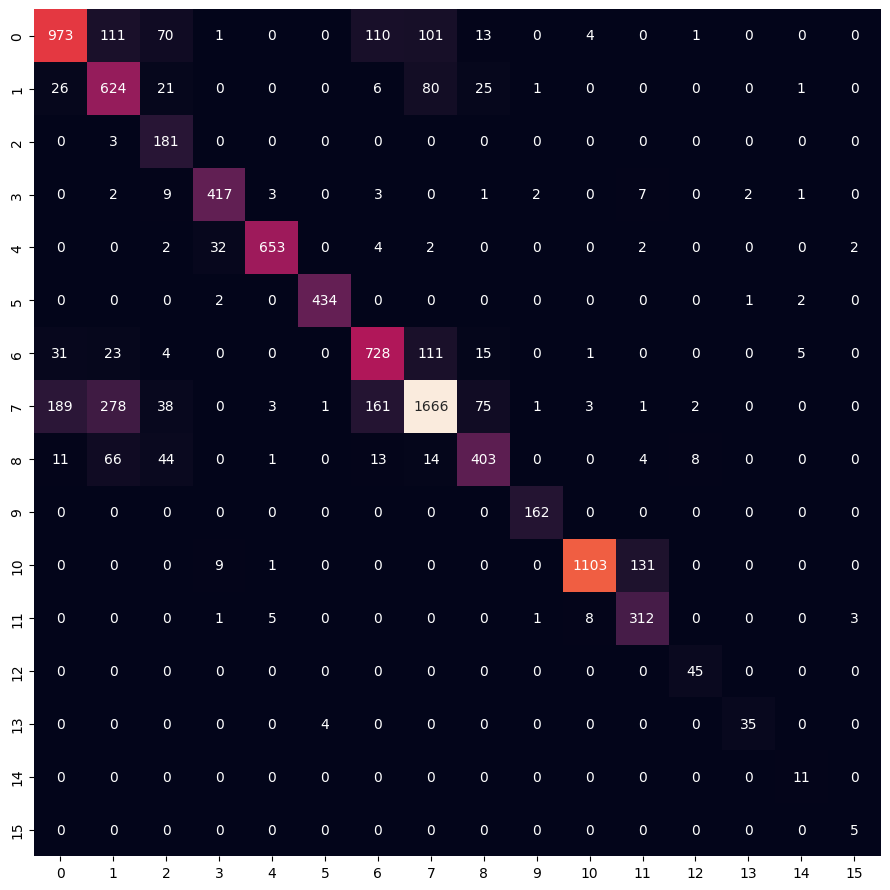

In [ ]:
plt.figure(figsize = (11,11))
sn.heatmap(confusion, square=True, annot=True, fmt='d', cbar=False)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
print(classification_report(y, x, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           1     0.7911    0.7030    0.7445      1384
           2     0.5637    0.7959    0.6600       784
           3     0.4905    0.9837    0.6546       184
           4     0.9026    0.9329    0.9175       447
           5     0.9805    0.9369    0.9582       697
           6     0.9886    0.9886    0.9886       439
           7     0.7102    0.7930    0.7494       918
           8     0.8440    0.6890    0.7587      2418
           9     0.7575    0.7145    0.7354       564
          10     0.9701    1.0000    0.9848       162
          11     0.9857    0.8867    0.9336      1244
          12     0.6827    0.9455    0.7929       330
          13     0.8036    1.0000    0.8911        45
          14     0.9211    0.8974    0.9091        39
          15     0.5500    1.0000    0.7097        11
          16     0.5000    1.0000    0.6667         5

    accuracy                         0.8016      9671
   macro avg     0.7776   

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y, x)

0.7748785826721184

In [ ]:
from sklearn.metrics import classification_report
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
c_p = (classification_report(y, x, target_names=target_names, digits=4, output_dict=True))
r = np.zeros(17)
for key in range(1,17):
  c = str(key)
  r[key] = round((c_p[c]['recall']),4)

print("Average accuracy:",round((sum(r)/16),4))

Average accuracy: 0.8917
